# Avito Data Exploration: Stage 0

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import textblob
import goslate
import pprint

from collections import Counter

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [2]:
# Load parameters file
with open('setup_param.json', 'r') as handle:
    setup_params = json.load(handle)

In [3]:
parent_path = setup_params['parent_dir']
data_path = setup_params['data_dir']
scripts_path = setup_params['scripts_dir']
train_csv_path = setup_params['train_csv']
test_csv_path = setup_params['test_csv']

## Helper Fuctions

In [4]:
gs = goslate.Goslate()

In [5]:
def translate_to_english(text):
    decode_text = text.decode('UTF-8')
    try:
        translated_text = textblob.TextBlob(decode_text).translate(to='en')
        return str(translated_text)
    except:
        return decode_text

## Load Train and Test Data

In [6]:
train_df = pd.read_csv(train_csv_path)

In [7]:
test_df = pd.read_csv(test_csv_path)

In [8]:
print 'Shape of train_df:', train_df.shape
print 'Shape of test_df:', test_df.shape

Shape of train_df: (1503424, 18)
Shape of test_df: (508438, 17)


In [9]:
print train_df.columns.values

['item_id' 'user_id' 'region' 'city' 'parent_category_name'
 'category_name' 'param_1' 'param_2' 'param_3' 'title' 'description'
 'price' 'item_seq_number' 'activation_date' 'user_type' 'image'
 'image_top_1' 'deal_probability']


## Exploring "deal_probability" Field (Training Exclusive):

In [10]:
print 'Number of null values:', train_df.deal_probability.isnull().sum()

Number of null values: 0


In [11]:
deal_probs = train_df.deal_probability

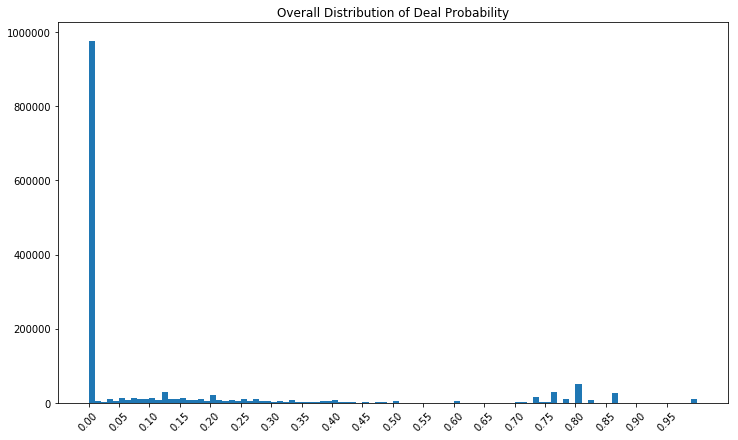

In [12]:
plt.figure(figsize=(12, 7))
deal_probs.hist(bins=100)
plt.title('Overall Distribution of Deal Probability')
plt.grid(False)
plt.xticks(np.arange(0, 1, step=0.05), rotation=45)
plt.show()

From the overall distribution plot above, it appears that the deal probability has a "long-tail" behavior. I will try to isolate the dense-end of the tail.

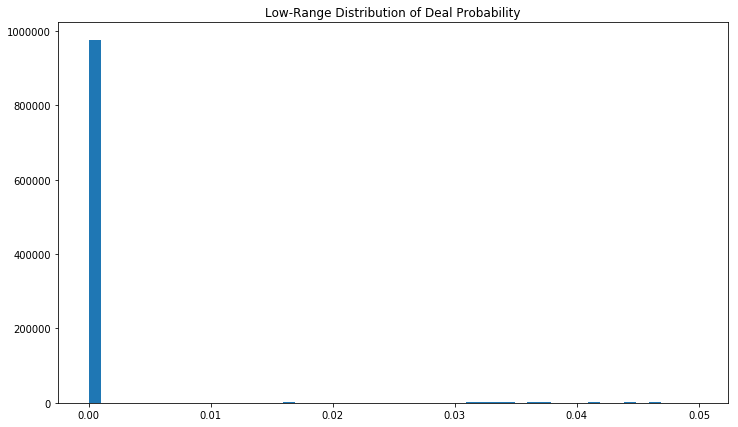

In [13]:
plt.figure(figsize=(12, 7))
deal_probs[deal_probs < 0.05].hist(bins=50)
plt.title('Low-Range Distribution of Deal Probability')
plt.grid(False)
plt.show()

In [14]:
probs_count = Counter(deal_probs.values)
sorted_counts = probs_count.most_common()
filtered_counts = list(filter(lambda x: x[1] > 150 and x[1] < 10000, sorted_counts))

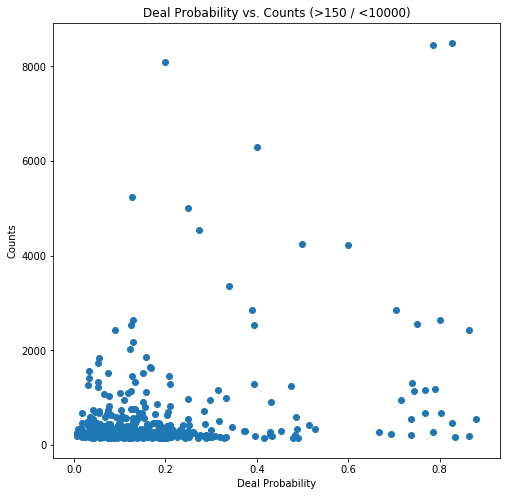

In [15]:
plt.figure(figsize=(8, 8))
plt.scatter([x[0] for x in filtered_counts], [x[1] for x in filtered_counts])
plt.title('Deal Probability vs. Counts (>150 / <10000)')
plt.xlabel('Deal Probability')
plt.ylabel('Counts')
plt.show()

## Exploring item_id and user_id Fields:

In [16]:
# Check for nans in train dataframe in these fields
train_df.loc[:][['item_id', 'user_id']].isnull().sum()

item_id    0
user_id    0
dtype: int64

In [17]:
# Check for nans in test dataframe in these fields
test_df.loc[:][['item_id', 'user_id']].isnull().sum()

item_id    0
user_id    0
dtype: int64

In [18]:
# Get overlap of item_id in train and test sets
train_item_id = np.array(list(set(train_df.item_id.values)))
test_item_id = np.array(list(set(test_df.item_id.values)))
item_intersect= np.intersect1d(train_item_id, test_item_id)
print 'Number of common entries in item_id field:', len(item_intersect)

Number of common entries in item_id field: 0


In [19]:
# Get overlap of user_id in train and test sets
train_user_id = np.array(list(set(train_df.user_id.values)))
test_user_id = np.array(list(set(test_df.user_id.values)))
user_intersect = np.intersect1d(train_user_id, test_user_id)
print 'Number of common entries in user_id field:', len(user_intersect)

Number of common entries in user_id field: 67929


In [20]:
print 'Ratio of shared elements in train set:', len(user_intersect)/float(len(train_user_id))
print 'Ratio of shared elements in test set:', len(user_intersect)/float(len(test_user_id))

Ratio of shared elements in train set: 0.0880172694161
Ratio of shared elements in test set: 0.22194015075


What this shows is that roughly 8.8% of the training set is repeated in the test set. This portion represents 22% of the test set (which is an appreciably large number).

## Exploring "region" Field:

In [21]:
# Check for nans in train dataframe in this field
train_df.region.isnull().sum()

0

In [22]:
# Check for nans in train dataframe in this field
test_df.region.isnull().sum()

0

In [23]:
train_regions_set = np.array(list(set(train_df.region.values)))
test_regions_set = np.array(list(set(test_df.region.values)))
regions_intersect = np.intersect1d(train_regions_set, test_regions_set)
print 'Number of regions in training set:', len(train_regions_set) 
print 'Number of regions in test set:', len(test_regions_set) 
print 'Number of shared regions between both sets:', len(regions_intersect) 

Number of regions in training set: 28
Number of regions in test set: 28
Number of shared regions between both sets: 28


In [24]:
translated_regions = [translate_to_english(region) for region in regions_intersect]

In [25]:
regions_dict = {}
for i, region in enumerate(regions_intersect):
    regions_dict[region] = translated_regions[i]

In [26]:
def region_lookup(regions, lookup):
    translated_list = []
    for region in regions:
        translated_list.append(lookup[region])
    return(translated_list)

In [27]:
translated_regions_train = region_lookup(train_df.region.values, regions_dict)
translated_regions_test = region_lookup(test_df.region.values, regions_dict)

In [28]:
train_regions_sizes = Counter(translated_regions_train)
test_regions_sizes = Counter(translated_regions_test)

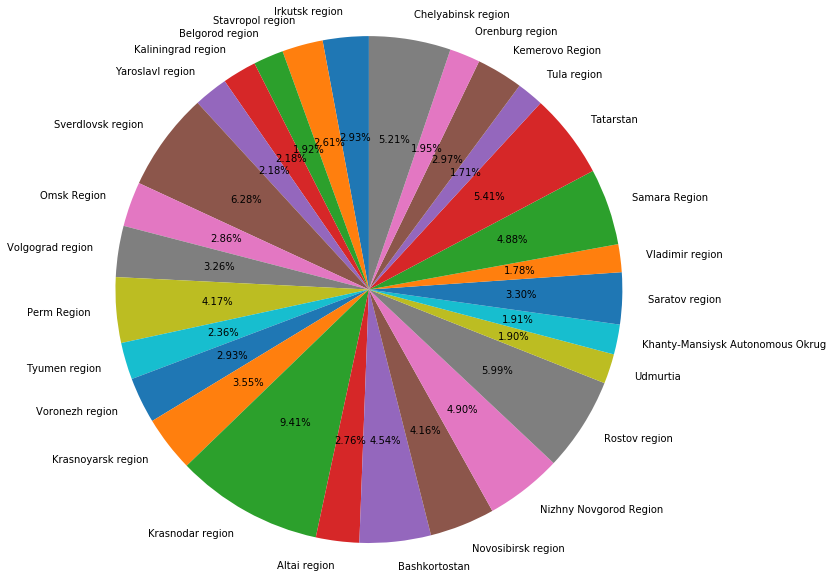

In [29]:
# Visualize train distribution
fig1, ax1 = plt.subplots(figsize=(10, 10))
ax1.pie([float(val)/len(translated_regions_train) for val in train_regions_sizes.values()], 
        labels=[lab for lab in train_regions_sizes], startangle=90, autopct='%1.2f%%')
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [30]:
# Compare train and test region distribution 
train_test_region = {}
for region in translated_regions:
    train_test_region[region] = [train_regions_sizes[region], test_regions_sizes[region]]
region_eval_df = pd.DataFrame.from_dict(train_test_region, orient='index')
region_eval_df.columns = ['train', 'test']
region_eval_df['train_percent'] = 100*np.divide(region_eval_df.train, float(len(translated_regions_train)))
region_eval_df['test_percent'] = 100*np.divide(region_eval_df.test, float(len(translated_regions_test)))
region_eval_df['abs_percent_diff'] = np.abs(region_eval_df.train_percent - region_eval_df.test_percent)

In [31]:
print 'Maximum percent difference in distribution between train and test:', np.amax(region_eval_df.abs_percent_diff)

Maximum percent difference in distribution between train and test: 0.7401319317258901


### Making "region" population dictionary

#### Coordinate Representation:
1 degree = 60 minutes (conversion factor)
* Longitutude:
    * East (negative)
    * West (positive)
* Latitude:
    * North (positive)
    * South (negative)

Key below: population, latitude (degrees, minutes), longitude (degrees, minutes), area (km2)

In [32]:
region_metadata = \
[[206168, 50, 55, -86, -55, 92600], [4072292, 54, 28, -56, -16, 143600], [1532526, 50, 46, -37, -27, 27100], 
 [1443693, 56, 5, -40, -37, 29000], [2610161, 49, 44, -44, -7, 113900], [2331100, 51, 3, -40, -9, 52400], 
 [2428750, 57, 22, -106, 0, 767900], [941873, 54, 48, -21, -25, 15100], [2763135, 54, 56, -87, -14, 95500],
 [5226647, 45, 22, -39, -26, 76000], [2828187, 59, 53, -91, -40, 2339700], [3310597, 56, 29, -44, -32, 76900],
 [2665911, 55, 27, -79, -33, 178200], [1977665, 56, 13, -73, -16, 139700], [2033072, 52, 8, -55, -36, 124000], 
 [2635276, 59, 14, -56, -8, 160600], [4277976, 47, 52, -41, -11, 100800], [3215532, 53, 27, -50, -27, 53600], 
 [2521892, 51, 47, -46, -44, 100200], [4297747, 58, 42, -61, -20, 194800], [2786281, 45, 3, -43, -16, 66500],
 [3786488, 55, 33, -50, -56, 68000], [1553925, 53, 55, -37, -35, 25700], [3395755, 57, 50, -69, 0, 1435200], 
 [1521420, 57, 17, -52, -45, 42100], [1532243, 62, 15, -70, -10, 534800], [3476217, 54, 32, -60, -20, 87900], 
 [1272468, 57, 52, -39, -12, 36400]]

In [33]:
region_meta_dict = {}
for i, region in enumerate(translated_regions):
    region_meta_dict[region] = region_metadata[i]

In [34]:
region_meta_df = pd.DataFrame.from_dict(region_meta_dict, orient='index')
region_meta_df.columns = ['population', 'lat_deg', 'lat_min', 'long_deg', 'long_min', 'area']
region_meta_df['latitude'] = np.round((region_meta_df.lat_deg + (region_meta_df.lat_min/60)), decimals=3)
region_meta_df['longitude'] = np.round((region_meta_df.long_deg + (region_meta_df.long_min/60)), decimals=3)
region_meta_df['density'] = np.round(np.divide(region_meta_df.population, 1.0*region_meta_df.area), decimals=3)

In [35]:
region_flag = True
region_cols_keep = ['population', 'area', 'latitude', 'longitude', 'density']
export_region_df = region_meta_df.loc[:][region_cols_keep]
if region_flag:
    export_region_df.to_csv(scripts_path + 'region_info_df.csv')
else:
    export_region_df = pd.read_csv(scripts_path + 'region_info_df.csv')

In [36]:
export_region_df = pd.read_csv(scripts_path + 'region_info_df.csv', index_col=0)
export_region_df.head()

,population,area,latitude,longitude,density
Irkutsk region,2428750,767900,57.367,-106.000,3.163
Stavropol region,2786281,66500,45.050,-43.267,41.899
Tula region,1553925,25700,53.917,-37.583,60.464
Samara Region,3215532,53600,53.450,-50.450,59.991
Yaroslavl region,1272468,36400,57.867,-39.200,34.958


## Exploring "city" Field:

In [37]:
# Check for nan in train dataframe
train_df.city.isnull().sum()

0

In [38]:
# Check for nan in test dataframe
test_df.city.isnull().sum()

0

In [39]:
def compare_similarity(train, test):
    train_set = list(set(train))
    test_set = list(set(test))
    intersect = np.intersect1d(train_set, test_set)
    print 'Length of train set:', len(train_set)
    print 'Length of test set:', len(test_set)
    print 'Number of common elements:', len(intersect)
    return(train_set, test_set, intersect)

In [40]:
city_train_set, city_test_set, city_intersect = compare_similarity(train_df.city.values, test_df.city.values)

Length of train set: 1733
Length of test set: 1644
Number of common elements: 1625


Many of the specific city fields cannot be translated using either Textblob or the Google Translate API. Moreover, whatever population or location information that the city name could've provided has already been accounted for by the inclusion of region data. As such, I will be leaving out the **city** field from the first-pass analysis and modeling.

## Exploring "parent_category_name" Field:

In [41]:
print 'Number of null elements for train_df:', train_df.parent_category_name.isnull().sum()
print 'Number of null elements for test_df:', test_df.parent_category_name.isnull().sum()

Number of null elements for train_df: 0
Number of null elements for test_df: 0


In [42]:
pcn_trainset, pcn_testset, pcn_intersect = compare_similarity(train_df.parent_category_name.values, 
                                                              test_df.parent_category_name.values)

Length of train set: 9
Length of test set: 9
Number of common elements: 9


In [43]:
# Get translations of parent category fields
pcn_translated = [translate_to_english(x) for x in pcn_intersect]
pprint.pprint(pcn_translated)
pcn_dictionary = {}
for i, categ in enumerate(pcn_intersect):
    pcn_dictionary[categ] = pcn_translated[i]

['Consumer electronics',
 'For business',
 'For home and cottages',
 'Animals',
 'Personal things',
 'The property',
 'Transport',
 'The services',
 'Hobbies and Recreation']


In [44]:
translated_train_pcn = [pcn_dictionary[x] for x in train_df.parent_category_name.values]
translated_test_pcn = [pcn_dictionary[x] for x in test_df.parent_category_name.values]

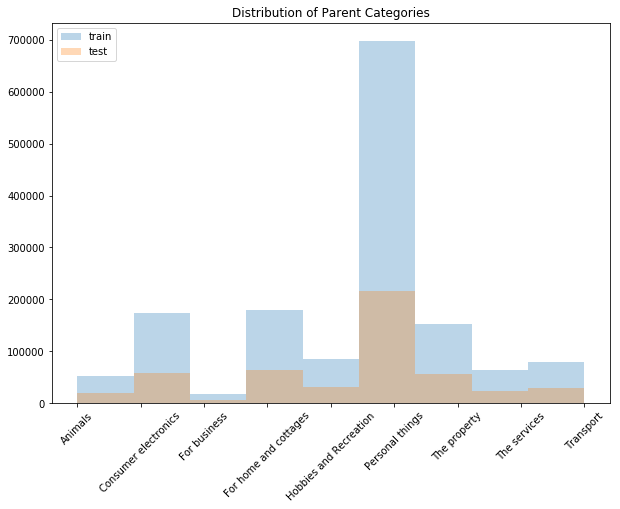

In [45]:
num_bins = len(pcn_translated)
plt.figure(figsize=(10, 7))
plt.hist(translated_train_pcn, alpha=0.3, label='train', bins=num_bins)
plt.hist(translated_test_pcn, alpha=0.3, label='test', bins=num_bins)
plt.legend(loc='upper left')
plt.title('Distribution of Parent Categories')
plt.xticks(rotation=45)
plt.show()

In [46]:
mlb = MultiLabelBinarizer()
train_pcn_onehot = mlb.fit_transform([[x] for x in translated_train_pcn])
test_pcn_onehot = mlb.fit_transform([[x] for x in translated_test_pcn])

## Exploring "category_name" Field:

In [47]:
print 'Number of null elements for train_df:', train_df.category_name.isnull().sum()
print 'Number of null elements for test_df:', test_df.category_name.isnull().sum()

Number of null elements for train_df: 0
Number of null elements for test_df: 0


In [48]:
categ_trainset, categ_testset, categ_intersect = compare_similarity(train_df.category_name.values, 
                                                                    test_df.category_name.values)

Length of train set: 47
Length of test set: 47
Number of common elements: 47


In [49]:
categs_translated = [translate_to_english(x) for x in categ_intersect]
categs_dictionary = {}
for i, categ in enumerate(categ_intersect):
    categs_dictionary[categ] = categs_translated[i]

In [50]:
translated_categs_train = [categs_dictionary[x] for x in train_df.category_name.values]
translated_categs_test = [categs_dictionary[x] for x in test_df.category_name.values]

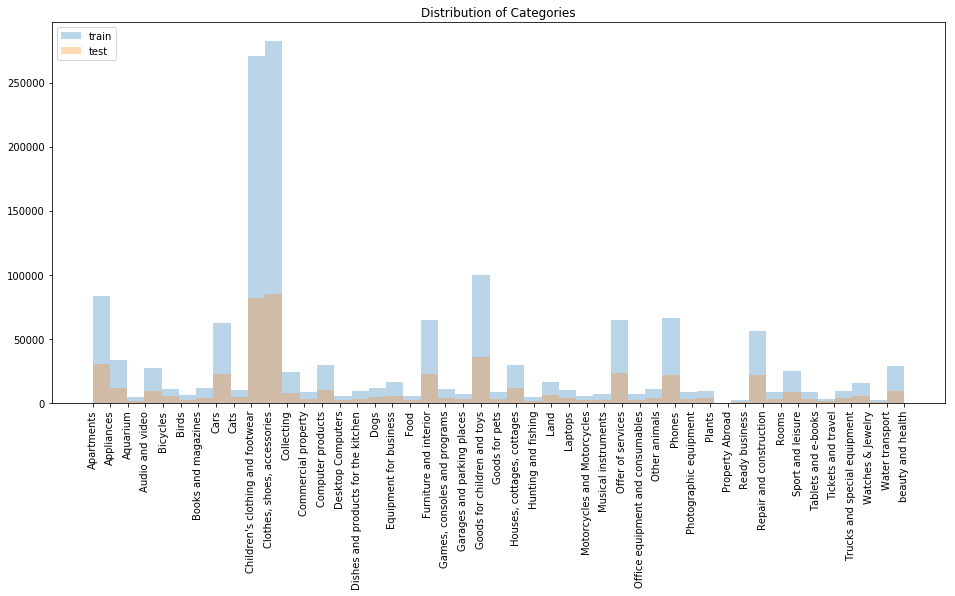

In [51]:
num_bins = len(categs_translated)
plt.figure(figsize=(16, 7))
plt.hist(translated_categs_train, alpha=0.3, label='train', bins=num_bins)
plt.hist(translated_categs_test, alpha=0.3, label='test', bins=num_bins)
plt.legend(loc='upper left')
plt.title('Distribution of Categories')
plt.xticks(rotation=90)
plt.show()

In [52]:
train_categs_onehot = mlb.fit_transform([[x] for x in translated_categs_train])
test_categs_onehot = mlb.fit_transform([[x] for x in translated_categs_test])

## Exploring "title" Field:

In [53]:
print 'Number of null elements for train_df:', train_df.title.isnull().sum()
print 'Number of null elements for test_df:', test_df.title.isnull().sum()

Number of null elements for train_df: 0
Number of null elements for test_df: 0


In [54]:
title_trainset, title_testset, title_intersect = compare_similarity(train_df.title.values, test_df.title.values)

Length of train set: 788377
Length of test set: 298039
Number of common elements: 64213


Since there are a considerable number of distinct titles, I won't make the effort at this stage to translate all of them to English. For now, the number of characters in each title will suffice. **(NOTE: The number of characters in the encoded Cyrillic version will differ from the English version. This is a discrepancy that will simply be accepted for now.)**

In [55]:
title_train_count = np.array([len(x) for x in train_df.title.values])
title_test_count = np.array([len(x) for x in test_df.title.values])

## Exploring "description" Field:

In [56]:
print 'Number of null elements for train_df:', train_df.description.isnull().sum()
print 'Number of null elements for test_df:', test_df.description.isnull().sum()

Number of null elements for train_df: 116276
Number of null elements for test_df: 0


In [57]:
descrip_trainset, descrip_testset, descrip_intersect = compare_similarity(train_df.description.values, 
                                                                          test_df.description.values)

Length of train set: 1317103
Length of test set: 485209
Number of common elements: 8339


A small subset of the total number of descriptions are shared between the train and test sets. At a later time, it may be interesting to explore what these overlapping descriptions are but for now, I will simply proceed with counting the number of characters per description. **(The note from the "title" field is applicable here, as well.)**

In [58]:
def description_count(descrip_list):
    count_list = []
    counter = 0
    for x in descrip_list:
        try:
            count_list.append(len(x))
        except TypeError:
            count_list.append(np.nan)
            counter += 1
    print 'Elements in count list:', len(count_list)
    print 'Elements that could not be counted:', counter
    return np.array(count_list)

In [59]:
descrip_train_count = description_count(train_df.description.values)
descrip_test_count = description_count(test_df.description.values)

descrip_train_series = pd.Series(descrip_train_count)
descrip_test_series = pd.Series(descrip_test_count)

Elements in count list: 1503424
Elements that could not be counted: 116276
Elements in count list: 508438
Elements that could not be counted: 0


Since there are a considerble number of **nan** values in the description, I am filling in these nan values in with 0.

In [60]:
descrip_train_series.fillna(0, inplace=True)
descrip_test_series.fillna(0, inplace=True)

## Exploring "user_type" Field:

In [61]:
print 'Number of null elements for train_df:', train_df.user_type.isnull().sum()
print 'Number of null elements for test_df:', test_df.user_type.isnull().sum()

Number of null elements for train_df: 0
Number of null elements for test_df: 0


In [62]:
user_trainset, user_testset, user_intersect = compare_similarity(train_df.user_type.values, test_df.user_type.values)

Length of train set: 3
Length of test set: 3
Number of common elements: 3


In [63]:
# Find distribution of user type in train and test data
train_usertype_count = Counter(train_df.user_type.values)
test_usertype_count = Counter(test_df.user_type.values)

print 'Training set breakdown:'
for key, val in train_usertype_count.items():
    print '%s breakdown: %f' % (key, float(val)/len(train_df))

print '\nTest set breakdown:'
for key, val in test_usertype_count.items():
    print '%s breakdown: %f' % (key, float(val)/len(test_df))

Training set breakdown:
Shop breakdown: 0.053524
Company breakdown: 0.230972
Private breakdown: 0.715504

Test set breakdown:
Shop breakdown: 0.059457
Company breakdown: 0.235917
Private breakdown: 0.704627


In [64]:
# One-hot encoding
train_usertype_onehot = mlb.fit_transform([[x] for x in train_df.user_type.values])
test_usertype_onehot = mlb.fit_transform([[x] for x in test_df.user_type.values])

## Assembling Preliminary Dataset

The following fields have a substantial amount of null values that cannot be filled in with a preset value. As such, I will be using a regressor to predict these values based on the features explored so far. These features include:
* region
* parent_category
* title
* description
* user_type

In [65]:
# Train region columns
train_regions_names = pd.DataFrame(translated_regions_train, columns=['reg_name'])
train_regions = pd.merge(train_regions_names, export_region_df, how='outer', left_on='reg_name', 
                         right_index=True).sort_index()
train_regions.drop(['reg_name'], axis=1, inplace=True)
# Test region columns
test_regions_names = pd.DataFrame(translated_regions_test, columns=['reg_name'])
test_regions = pd.merge(test_regions_names, export_region_df, how='outer', left_on='reg_name', 
                        right_index=True).sort_index()
test_regions.drop(['reg_name'], axis=1, inplace=True)

In [66]:
# Parent category one-hot
train_pcn = pd.DataFrame(train_pcn_onehot, columns=['pcn_%s'%i for i in range(train_pcn_onehot.shape[1])])
test_pcn = pd.DataFrame(test_pcn_onehot, columns=['pcn_%s'%i for i in range(test_pcn_onehot.shape[1])])

In [67]:
# Title character count
train_title = pd.DataFrame(title_train_count, columns=['title_count'])
test_title = pd.DataFrame(title_test_count, columns=['title_count'])

In [68]:
# Description character count
train_desc = pd.DataFrame(descrip_train_series, columns=['desc_count'])
test_desc = pd.DataFrame(descrip_test_series, columns=['desc_count'])

In [69]:
# User type one-hot
train_usertype = pd.DataFrame(train_usertype_onehot, columns=['usetyp_%s'%i for i in 
                                                              range(train_usertype_onehot.shape[1])])
test_usertype = pd.DataFrame(test_usertype_onehot, columns=['usetyp_%s'%i for i in 
                                                              range(test_usertype_onehot.shape[1])])

### Assemble Prediction DataFrame:

In [70]:
pred_train_df = pd.concat([train_regions, train_pcn, train_title, train_desc, train_usertype], axis=1)
pred_test_df = pd.concat([test_regions, test_pcn, test_title, test_desc, test_usertype], axis=1)

In [71]:
print 'Shape of prediction train dataframe:', pred_train_df.shape
print 'Shape of prediction test dataframe:', pred_test_df.shape

Shape of prediction train dataframe: (1503424, 19)
Shape of prediction test dataframe: (508438, 19)


### Regression Models:

In [72]:
def train_regressor(params, xtrain, xval, ytrain, yval):
    clf = GradientBoostingRegressor(**params)
    clf.fit(xtrain, ytrain)
    # Predictions
    train_pred = clf.predict(xtrain)
    val_pred = clf.predict(xval)
    print 'Training error:', mean_absolute_error(ytrain, train_pred)
    print 'Validation error:', mean_absolute_error(yval, val_pred)

In [73]:
def get_predictions(params, xtrain, xtest, ytrain):
    clf = GradientBoostingRegressor(**params)
    clf.fit(xtrain, ytrain)
    # Predictions
    test_pred = clf.predict(xtest)
    return test_pred

## Exploring "price" Field:

In [74]:
print 'Number of null elements for train_df:', train_df.price.isnull().sum()
print 'Number of null elements for test_df:', test_df.price.isnull().sum()

Number of null elements for train_df: 85362
Number of null elements for test_df: 30585


There are a considerable number of elements in the **price** field for the training and test set that contain null values. These will be filled in with the average of all other entries.

In [75]:
# Training data
price_train_trainset = train_df.price[-train_df.price.isnull()]
price_train_testset = train_df.price[train_df.price.isnull()]
# Testing data
price_test_trainset = test_df.price[-test_df.price.isnull()]
price_test_testset = test_df.price[test_df.price.isnull()]

### Training Set Price Visualization:

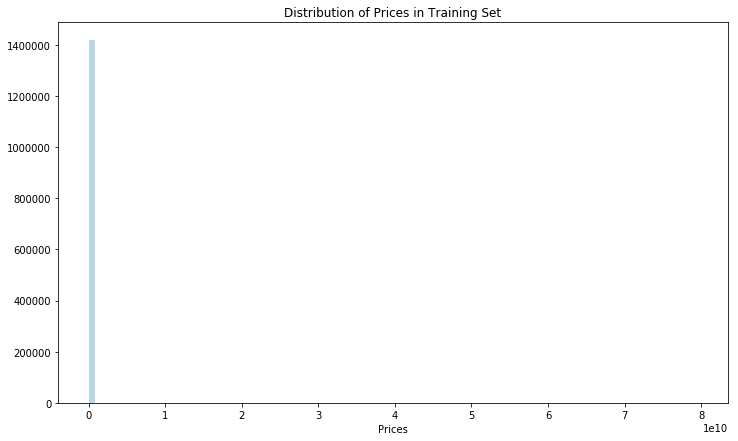

In [76]:
plt.figure(figsize=(12, 7))
plt.hist(price_train_trainset, bins=100, alpha=0.3, label='train')
plt.title('Distribution of Prices in Training Set')
plt.xlabel('Prices')
plt.show()

In [77]:
train_prices_dict = Counter(price_train_trainset)
train_prices_common = train_prices_dict.most_common()
print 'Most common prices:'
pprint.pprint(train_prices_common[:10])

Most common prices:
[(500.0, 115875),
 (1000.0, 88415),
 (300.0, 65823),
 (1500.0, 56543),
 (2000.0, 46368),
 (200.0, 44825),
 (400.0, 42085),
 (100.0, 34844),
 (3000.0, 33044),
 (700.0, 31283)]


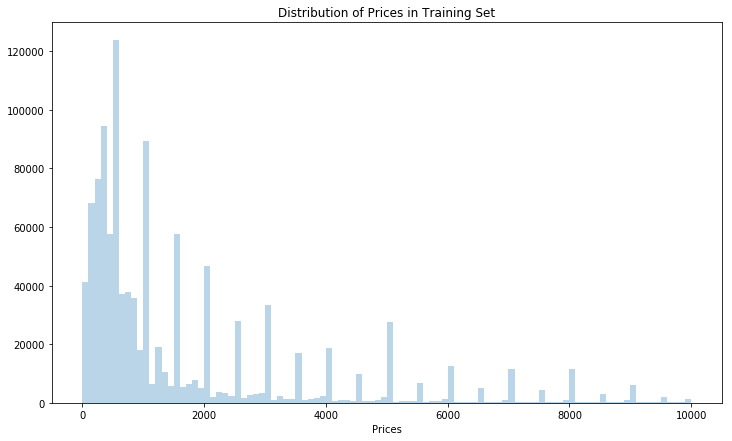

In [78]:
plt.figure(figsize=(12, 7))
plt.hist(price_train_trainset[price_train_trainset < 10000], bins=100, alpha=0.3, label='train')
plt.title('Distribution of Prices in Training Set')
plt.xlabel('Prices')
plt.show()

### Test Set Price Visualization:

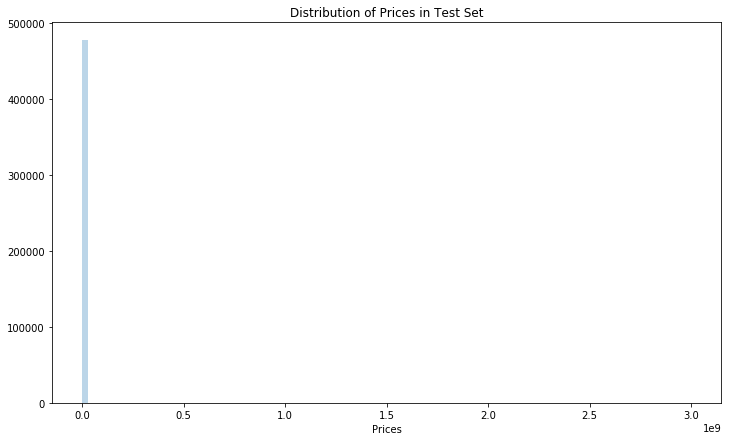

In [79]:
plt.figure(figsize=(12, 7))
plt.hist(price_test_trainset, bins=100, alpha=0.3, label='test')
plt.title('Distribution of Prices in Test Set')
plt.xlabel('Prices')
plt.show()

In [80]:
test_prices_dict = Counter(price_test_trainset)
test_prices_common = test_prices_dict.most_common()
print 'Most common prices:'
pprint.pprint(test_prices_common[:10])

Most common prices:
[(500.0, 36024),
 (1000.0, 27689),
 (300.0, 20502),
 (1500.0, 17598),
 (200.0, 14739),
 (2000.0, 14598),
 (400.0, 13532),
 (100.0, 11474),
 (3000.0, 10969),
 (700.0, 9877)]


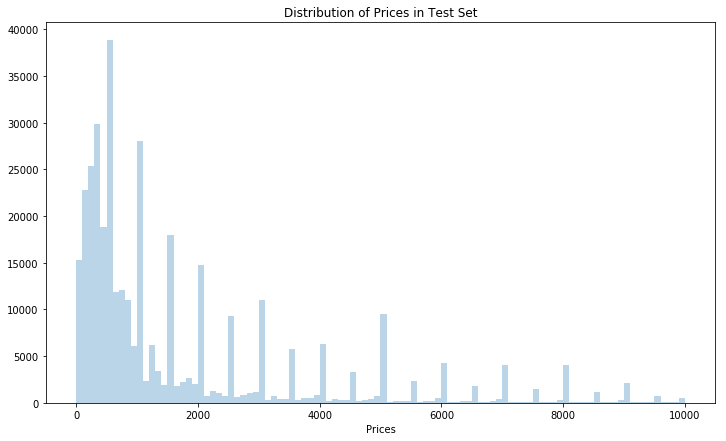

In [81]:
plt.figure(figsize=(12, 7))
plt.hist(price_test_trainset[price_test_trainset < 10000], bins=100, alpha=0.3, label='test')
plt.title('Distribution of Prices in Test Set')
plt.xlabel('Prices')
plt.show()

### Boxplots of Prices:

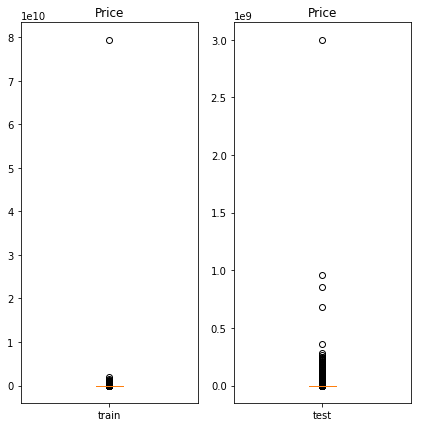

In [82]:
plt.figure(figsize=(7, 7))
plt.subplot(1, 2, 1)
plt.boxplot(price_train_trainset)
plt.xticks([1], ['train'])
plt.title('Price')
plt.subplot(1, 2, 2)
plt.boxplot(price_test_trainset)
plt.xticks([1], ['test'])
plt.title('Price')
plt.show()

Looking at the distribution of prices, it can be seen that there is an extreme outlier in the training set that is causing severe scaling distortion. I will proceed to analyze the occurrences of these values.

In [83]:
print 'Maximum price in training set:\n', price_train_trainset.nlargest(5)
print 'Maximum price in test set:\n', price_test_trainset.nlargest(5)

Maximum price in training set:
1418253    7.950101e+10
958131     2.000025e+09
1223334    1.600025e+09
47509      1.170000e+09
861574     1.100000e+09
Name: price, dtype: float64
Maximum price in test set:
330798    3.000060e+09
453735    9.609281e+08
472028    8.510460e+08
161583    6.800000e+08
165676    3.600000e+08
Name: price, dtype: float64


### Make Predictions on Prices:

To fill in values for prices, I will train and tune a gradient boosted regressor model to generate values for the unknown fields.

In [84]:
# Training set model tuning
xtrain, xval, ytrain, yval = train_test_split(pred_train_df.iloc[price_train_trainset.index], price_train_trainset, 
                                              test_size=0.3, random_state=0)
params = {'n_estimators': 40, 'max_depth': 3, 'min_samples_split': 3,
          'learning_rate': 0.04, 'loss': 'ls', 'verbose': True}
train_regressor(params, xtrain, xval, ytrain, yval)

      Iter       Train Loss   Remaining Time 
         1 6386774725255084.0000           56.49s
         2 6386217217626852.0000           53.55s
         3 6385703414363416.0000           51.83s
         4 6385229457218628.0000           51.05s
         5 6384792554216730.0000           49.47s
         6 6384389502393708.0000           48.13s
         7 6384017954377790.0000           46.82s
         8 6383675165210776.0000           45.24s
         9 6383359161434965.0000           43.87s
        10 6383067590802476.0000           42.64s
        20 6380711181078378.0000           29.19s
        30 6375244160027352.0000           14.41s
        40 6364521317768920.0000            0.00s
Training error: 426737.331804353
Validation error: 338981.03857913084


In [85]:
# Training set predictions
train_price_pred = get_predictions(params, pred_train_df.iloc[price_train_trainset.index], 
                                   pred_train_df.iloc[price_train_testset.index], price_train_trainset)

      Iter       Train Loss   Remaining Time 
         1 4474147890839887.0000            1.47m
         2 4473845841626513.0000            1.44m
         3 4473567263946979.0000            1.34m
         4 4473310199255759.5000            1.30m
         5 4473073095440071.5000            1.26m
         6 4472854278139280.0000            1.22m
         7 4472652437618025.0000            1.19m
         8 4472466142628345.0000            1.15m
         9 4472294288649563.0000            1.12m
        10 4472135651626291.0000            1.09m
        20 4470877117478822.5000           43.98s
        30 4466281100108903.0000           22.90s
        40 4461616583627522.5000            0.00s


In [86]:
# Test set model tuning
xtrain, xval, ytrain, yval = train_test_split(pred_test_df.iloc[price_test_trainset.index], price_test_trainset, 
                                              test_size=0.3, random_state=0)
params = {'n_estimators': 60, 'max_depth': 4, 'min_samples_split': 3,
          'learning_rate': 0.05, 'loss': 'ls', 'verbose': True}
train_regressor(params, xtrain, xval, ytrain, yval)

      Iter       Train Loss   Remaining Time 
         1 38746269017548.6562           26.80s
         2 38615303531276.7969           24.65s
         3 38497023145867.7031           23.72s
         4 38364133039884.3359           22.91s
         5 38267471118187.9609           22.44s
         6 38156657709568.6562           21.90s
         7 38035242509090.0000           21.43s
         8 37925651159226.2812           20.96s
         9 37825950263239.0156           20.58s
        10 37733136809082.7891           20.41s
        20 37227689768255.6094           14.85s
        30 36858135662247.0078           10.69s
        40 36454326371254.6641            7.10s
        50 35848695591756.3828            3.65s
        60 34852002789674.0195            0.00s
Training error: 257096.91404652497
Validation error: 252539.85167101238


In [87]:
# Test set predictions
test_price_pred = get_predictions(params, pred_test_df.iloc[price_test_trainset.index], 
                                   pred_test_df.iloc[price_test_testset.index], price_test_trainset)

      Iter       Train Loss   Remaining Time 
         1 28674939902178.1875           46.70s
         2 28584803876928.7461           44.27s
         3 28503310344878.9648           43.15s
         4 28428609886252.4414           42.38s
         5 28362746086139.3438           41.73s
         6 28299970471657.2930           40.80s
         7 28246081418275.1328           40.44s
         8 28175682933387.5859           39.36s
         9 28130566097460.8047           38.33s
        10 28090536511023.8047           37.46s
        20 27631510811457.2812           29.22s
        30 27166306404292.1016           21.76s
        40 26889545949109.1914           14.45s
        50 26645586378573.4375            7.20s
        60 26323524643402.3281            0.00s


### Fill in Predictions:

In [88]:
train_price_all = train_df.price.copy(deep=True)
test_price_all = test_df.price.copy(deep=True)

In [89]:
train_price_all.iloc[price_train_testset.index] = train_price_pred
test_price_all.iloc[price_test_testset.index] = test_price_pred

In [90]:
# Find invalid negative entries
invalid_train_price = train_price_all[train_price_all<0].index
invalid_test_price = test_price_all[test_price_all<0].index

In [91]:
# Set invalid negative entries to 0
train_price_all.iloc[invalid_train_price] = 0
test_price_all.iloc[invalid_test_price] = 0

In [92]:
print 'Number of null elements in final train prices:', train_price_all.isnull().sum()
print 'Number of null elements in final test prices:', test_price_all.isnull().sum()

Number of null elements in final train prices: 0
Number of null elements in final test prices: 0


### Update Preprocessed Data Assembly

In [93]:
pred_train_df['price'] = train_price_all
pred_test_df['price'] = test_price_all

## Exploring "image_top_1" Field:

In [94]:
print 'Number of null elements for train_df:', train_df.image_top_1.isnull().sum()
print 'Number of null elements for test_df:', test_df.image_top_1.isnull().sum()

Number of null elements for train_df: 112588
Number of null elements for test_df: 42609


In [95]:
train_imagetop = train_df.image_top_1.copy(deep=True)
test_imagetop = test_df.image_top_1.copy(deep=True)

In [96]:
# Training null / valid split
train_imgvalid = train_imagetop.dropna()
train_imgnull = train_imagetop[train_imagetop.isnull()]
# Test null / valid split
test_imgvalid = test_imagetop.dropna()
test_imgnull = test_imagetop[test_imagetop.isnull()]

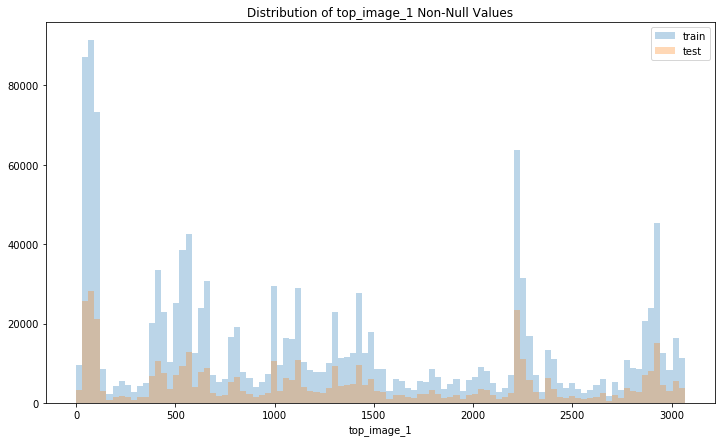

In [97]:
plt.figure(figsize=(12, 7))
plt.hist(train_imgvalid, alpha=0.3, bins=100, label='train')
plt.hist(test_imgvalid, alpha=0.3, bins=100, label='test')
plt.legend(loc='upper right')
plt.title('Distribution of top_image_1 Non-Null Values')
plt.xlabel('top_image_1')
plt.show()

The distributions between the training and test set appear to match up very well across all the values of **top_image_1** that are not null. I will now proceed to estimate the unknown values using a Gradient Boosted Regressor.

### Make Predictions:

In [98]:
xtrain, xval, ytrain, yval = train_test_split(pred_train_df.iloc[train_imgvalid.index], train_imgvalid, test_size=0.3,
                                              random_state=0)
params = {'n_estimators': 60, 'max_depth': 4, 'min_samples_split': 3,
          'learning_rate': 0.15, 'loss': 'ls', 'verbose': True}
train_regressor(params, xtrain, xval, ytrain, yval)

      Iter       Train Loss   Remaining Time 
         1      746203.5909            2.52m
         2      604435.4196            2.38m
         3      501737.5641            2.43m
         4      427397.6091            2.42m
         5      372681.6567            2.41m
         6      333469.0081            2.38m
         7      304599.6614            2.34m
         8      283716.5044            2.30m
         9      268697.1870            2.27m
        10      257622.7524            2.23m
        20      228644.7418            1.76m
        30      225745.0031            1.31m
        40      224866.5747           51.74s
        50      224325.3618           25.59s
        60      224012.6449            0.00s
Training error: 328.99895770357483
Validation error: 329.7157435805332


In [99]:
train_img_pred = get_predictions(params, pred_train_df.iloc[train_imgvalid.index], 
                                 pred_train_df.iloc[train_imgnull.index], train_imgvalid)

      Iter       Train Loss   Remaining Time 
         1      746006.3179            4.08m
         2      604400.1667            3.99m
         3      501785.5628            4.00m
         4      427503.6141            3.99m
         5      372894.3170            3.98m
         6      333738.1883            3.88m
         7      304904.1498            3.81m
         8      284021.8656            3.73m
         9      269009.5500            3.65m
        10      257936.1283            3.58m
        20      228720.1362            2.83m
        30      225966.1504            2.08m
        40      225137.3099            1.36m
        50      224654.0873           39.85s
        60      224283.0822            0.00s


In [100]:
xtrain, xval, ytrain, yval = train_test_split(pred_test_df.iloc[test_imgvalid.index], test_imgvalid, test_size=0.3,
                                              random_state=0)
params = {'n_estimators': 70, 'max_depth': 4, 'min_samples_split': 3,
          'learning_rate': 0.2, 'loss': 'ls', 'verbose': True}
train_regressor(params, xtrain, xval, ytrain, yval)

      Iter       Train Loss   Remaining Time 
         1      679190.7631           37.90s
         2      521873.6967           37.41s
         3      420752.1540           36.86s
         4      354300.6862           36.54s
         5      311734.0991           35.87s
         6      284669.1322           35.32s
         7      266829.5223           34.79s
         8      255418.5941           34.27s
         9      247927.2534           33.64s
        10      243038.0040           32.99s
        20      231354.1528           26.24s
        30      229881.1430           19.69s
        40      229156.8368           14.19s
        50      228532.6789            9.29s
        60      228052.5369            4.59s
        70      227618.2552            0.00s
Training error: 329.5806111346591
Validation error: 330.18137303145966


In [101]:
test_img_pred = get_predictions(params, pred_test_df.iloc[test_imgvalid.index], 
                                pred_test_df.iloc[test_imgnull.index], test_imgvalid)

      Iter       Train Loss   Remaining Time 
         1      678631.7290            1.03m
         2      521469.3989           59.77s
         3      420357.5095           58.53s
         4      354069.6262           57.52s
         5      311524.6883           56.62s
         6      284460.0913           55.59s
         7      266645.0571           54.71s
         8      255233.2676           53.74s
         9      247718.1436           52.82s
        10      242746.5148           51.80s
        20      231121.9539           42.23s
        30      229438.5990           31.76s
        40      228830.9494           23.23s
        50      228395.4212           15.09s
        60      228009.7539            7.41s
        70      227683.7283            0.00s


### Fill in Predictions:

In [102]:
train_imagetop.iloc[train_imgnull.index] = train_img_pred
test_imagetop.iloc[test_imgnull.index] = test_img_pred

In [103]:
# Find invalid negative entries
invalid_train_img = train_imagetop[train_imagetop<0].index
invalid_test_img = test_imagetop[test_imagetop<0].index

In [104]:
# Set invaild negative entries to 0
train_imagetop[invalid_train_img] = 0
test_imagetop[invalid_test_img] = 0

In [105]:
print 'Number of null elements in final train image top 1:', train_imagetop.isnull().sum()
print 'Number of null elements in final test image top 1:', test_imagetop.isnull().sum()

Number of null elements in final train image top 1: 0
Number of null elements in final test image top 1: 0


### Update Preprocessed Data Assembly

In [106]:
pred_train_df['image_top_1'] = train_imagetop
pred_test_df['image_top_1'] = test_imagetop

## Verify Preprocessing and Save:

In [107]:
# Training dataset
pred_train_df.head(1)

,population,area,latitude,longitude,density,pcn_0,pcn_1,pcn_2,pcn_3,pcn_4,...,pcn_6,pcn_7,pcn_8,title_count,desc_count,usetyp_0,usetyp_1,usetyp_2,price,image_top_1
0,4297747,194800,58.7,-61.333,22.062,0,0,0,0,0,...,0,0,0,38,108.0,0,1,0,400.0,1008.0


In [108]:
pred_train_df.isnull().sum()

population     0
area           0
latitude       0
longitude      0
density        0
pcn_0          0
pcn_1          0
pcn_2          0
pcn_3          0
pcn_4          0
pcn_5          0
pcn_6          0
pcn_7          0
pcn_8          0
title_count    0
desc_count     0
usetyp_0       0
usetyp_1       0
usetyp_2       0
price          0
image_top_1    0
dtype: int64

In [109]:
# Test dataset
pred_test_df.head(1)

,population,area,latitude,longitude,density,pcn_0,pcn_1,pcn_2,pcn_3,pcn_4,...,pcn_6,pcn_7,pcn_8,title_count,desc_count,usetyp_0,usetyp_1,usetyp_2,price,image_top_1
0,2610161,113900,49.733,-44.117,22.916,0,0,0,0,0,...,0,0,0,29,23,0,1,0,18419.966935,2020.0


In [110]:
pred_test_df.isnull().sum()

population     0
area           0
latitude       0
longitude      0
density        0
pcn_0          0
pcn_1          0
pcn_2          0
pcn_3          0
pcn_4          0
pcn_5          0
pcn_6          0
pcn_7          0
pcn_8          0
title_count    0
desc_count     0
usetyp_0       0
usetyp_1       0
usetyp_2       0
price          0
image_top_1    0
dtype: int64

In [117]:
# Save datasets
preprocess_train = setup_params['stage0_train']
preprocess_test = setup_params['stage0_test']

pred_train_df.to_csv(preprocess_train, index=None)
pred_test_df.to_csv(preprocess_test, index=None)

In [118]:
# Validate save
train_load = pd.read_csv(preprocess_train)
test_load = pd.read_csv(preprocess_test)

In [119]:
print 'Shape of training data:', train_load.shape
print 'Shape of test data:', test_load.shape

Shape of training data: (1503424, 21)
Shape of test data: (508438, 21)


## Visualizing Split Candidates:

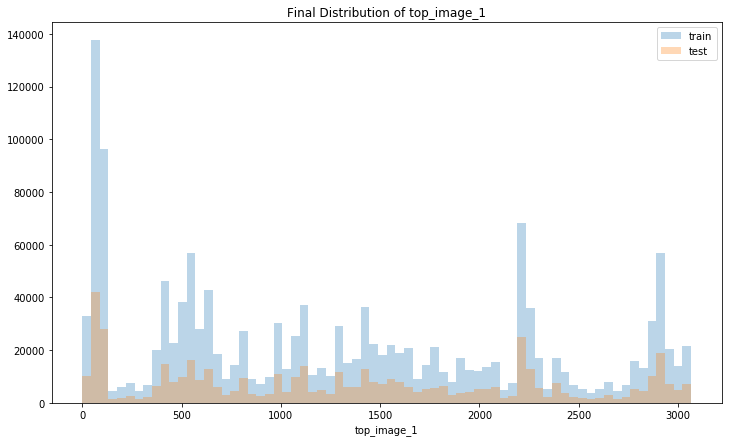

In [120]:
plt.figure(figsize=(12, 7))
train_load.image_top_1.hist(bins=70, alpha=0.3, label='train')
test_load.image_top_1.hist(bins=70, alpha=0.3, label='test')
plt.title('Final Distribution of top_image_1')
plt.xlabel('top_image_1')
plt.legend(loc='upper right')
plt.grid(False)
plt.show()

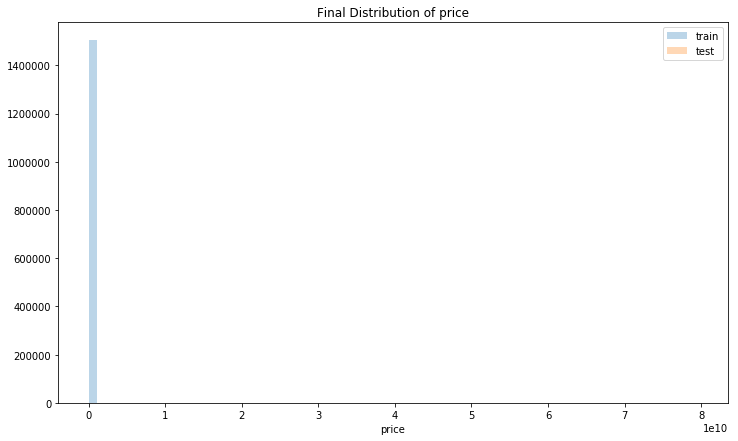

In [121]:
plt.figure(figsize=(12, 7))
train_load.price.hist(bins=70, alpha=0.3, label='train')
test_load.price.hist(bins=70, alpha=0.3, label='test')
plt.title('Final Distribution of price')
plt.xlabel('price')
plt.legend(loc='upper right')
plt.grid(False)
plt.show()

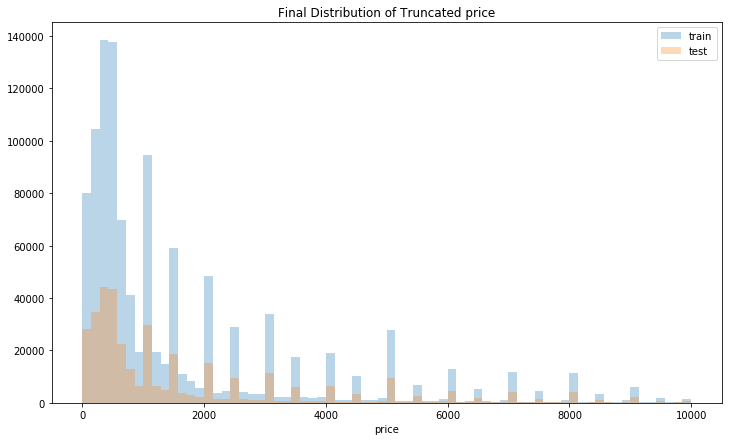

In [122]:
cutoff = 10000
plt.figure(figsize=(12, 7))
train_load.price[train_load.price<cutoff].hist(bins=70, alpha=0.3, label='train')
test_load.price[test_load.price<cutoff].hist(bins=70, alpha=0.3, label='test')
plt.title('Final Distribution of Truncated price')
plt.xlabel('price')
plt.legend(loc='upper right')
plt.grid(False)
plt.show()